# Computational Reproducibility

You can run this notebook on Google Colab to reproduce the results of the manuscript using the following link: https://colab.research.google.com/github/rederoth/LPA_experimental_code/blob/main/Analysis/psysci_figures.ipynb#scrollTo=bWEpCJcuANZP

If you run it on your local machine, please adjust the paths accordingly.

In [ ]:
# necessary for colab, not for local execution
!git clone https://github.com/rederoth/LPA_experimental_code.git
!pip install pymatreader

import os
os.chdir('/content/LPA_experimental_code/')
!wget https://osf.io/ey4ws/download -O LPA_5s_eval_all.zip
!unzip LPA_5s_eval_all.zip -d Data/

os.chdir('/content/LPA_experimental_code/Stimuli/')
!wget https://osf.io/vrjqa/download -O catcafe.png 
!wget https://osf.io/nk7fr/download -O  trinkvogel2.png 

os.chdir('/content/LPA_experimental_code/Analysis/')
!wget https://osf.io/nvjmy/download -O df_all_fovs_psycsci.csv.gz
!wget https://osf.io/dbntq/download -O df_obj_dt_diff_psycsci.csv.gz 
!wget https://osf.io/q32pn/download -O df_obj_props_psycsci.csv.gz  
!wget https://osf.io/hezyg/download -O results-survey438778_LPA.csv 


In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr

import utils
import evaluate_metrics_psychsci_hpc as em

sns.set(style='ticks')

In [2]:
# When running it locally, please make sure to set the correct paths
RUN_LOCALLY = True
if RUN_LOCALLY:
    csv_base_path = '/home/nico/project_code/LPA_analysis/'
    dataset_base_path = '/home/nico/project_code/LPA_study/'
    EVAL_PATH = '/home/nico/project_code/LPA_analysis/LPA_5s_eval_psycsci/'
else:
    csv_base_path = ''
    dataset_base_path = '/content/LPA_experimental_code/'
    EVAL_PATH = f'{dataset_base_path}Data/'
    
df_all = pd.read_csv(f'{csv_base_path}df_all_fovs_psycsci.csv.gz', compression='gzip')
df_obj = pd.read_csv(f'{csv_base_path}df_obj_props_psycsci.csv.gz', compression='gzip')
df_obj_dt = pd.read_csv(f'{csv_base_path}df_obj_dt_diff_psycsci.csv.gz', compression='gzip')
survey_df = pd.read_csv(f'{csv_base_path}results-survey438778_LPA.csv')
IMG_PATH = f'{dataset_base_path}Stimuli/'
RATING_PATH = f'{dataset_base_path}ExpertRatings/'

subj_ids = sorted([f[7:9] for f in os.listdir(EVAL_PATH) if "_all_hpc.csv.gz" in f])
print("#Subjects:",len(subj_ids), ", IDS:", subj_ids)

DF_PFA = em.create_expert_df(RATING_PATH)

#Subjects: 20 , IDS: ['01', '02', '03', '04', '05', '06', '07', '08', '10', '11', '12', '13', '14', '15', '16', '18', '19', '20', '22', '23']
Olga /home/nico/project_code/LPA_study/ExpertRatings/Olga_ratings.csv
Lynn /home/nico/project_code/LPA_study/ExpertRatings/Lynn_ratings.csv
Angelica /home/nico/project_code/LPA_study/ExpertRatings/Angelica_ratings.csv
Vito /home/nico/project_code/LPA_study/ExpertRatings/Vito_ratings.csv
Robert /home/nico/project_code/LPA_study/ExpertRatings/Robert_ratings.csv


## Participant information

In [3]:
survey_df.dropna(subset=['Probandennummer'], inplace=True)
survey_df['subj_id'] = survey_df["Probandennummer"].astype(int).astype(str).str.zfill(2)
survey_df = survey_df[survey_df['subj_id'].isin(subj_ids)]
survey_df.reset_index(drop=True, inplace=True)
survey_df.head()

Antwort ID    Datum Abgeschickt  Letzte Seite Start-Sprache  \
0           9  2022-11-24 14:48:26           1.0            de   
1          10  2022-11-25 09:05:56           1.0            en   
2          11  2022-11-25 10:45:40           1.0            en   
3          12  2022-11-25 15:14:21           1.0            en   
4          13  2022-11-25 16:34:10           1.0            en   

   Zufallsgeneratorstartwert      Datum gestartet Datum letzte Aktivität  \
0               1.087148e+09  2022-11-24 13:33:04    2022-11-24 14:48:26   
1               1.584428e+09  2022-11-25 08:45:47    2022-11-25 09:05:56   
2               1.910715e+09  2022-11-25 10:41:45    2022-11-25 10:45:40   
3               4.234958e+08  2022-11-25 14:55:13    2022-11-25 15:14:21   
4               1.212976e+07  2022-11-25 16:28:42    2022-11-25 16:34:10   

  Teilnehmenden-Identifikationscode   Probandennummer  Alter Geschlecht  \
0   0031550c04369d6912a1587e7af23611              1.0   25.0   Männlich   
1   bf46b6044c55bcc1556d2ca963b2a6c8              2.0   38.0   Weiblich   
2   90386646DB3585BF14BFD29BC96AF51B              3.0   36.0   Weiblich   
3   ceecce3c2dc6d1c2a1ef1706bfb054ed              4.0   36.0   Weiblich   
4   f3c1a492bf37726c0460af8d33d7d682              5.0   26.0   Männlich   

   Geschlecht [Sonstiges] Dominantes Auge Händigkeit Sehhilfe  \
0                     NaN           Links     Rechts   Brille   
1                     NaN           Links     Rechts    Keine   
2                     NaN          Rechts     Rechts    Keine   
3                     NaN          Rechts     Rechts    Keine   
4                     NaN           Links     Rechts   Brille   

             Sehschärfe  Sehschärfe [Sonstiges] subj_id  
0  20/20: normale Sicht                     NaN      01  
1  20/20: normale Sicht                     NaN      02  
2  20/20: normale Sicht                     NaN      03  
3  20/20: normale Sicht                     NaN      04  
4  20/20: normale Sicht                     NaN      05

In [8]:
print("mean age", survey_df["Alter"].mean(), "min age", survey_df["Alter"].min(), "max age", survey_df["Alter"].max())
print(survey_df["Geschlecht"].value_counts())
print(survey_df["Händigkeit"].value_counts())

mean age 27.95 min age 21.0 max age 38.0
Männlich    10
Weiblich    10
Name: Geschlecht, dtype: int64
Rechts        18
Beidhändig     1
Links          1
Name: Händigkeit, dtype: int64


## Qualitative scanpaths

To get a qualitative understanding of how the scanpaths in the different conditions depend on the "Potential for Action/Change" of a scene, we look into two qualitative examples.

Subject 02


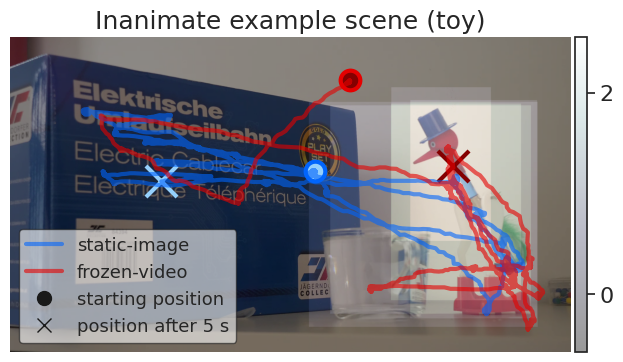

In [9]:
def plot_qualitative_on_scene(scene, subject_id, title, maxpfa, inc_cbartext=False, inc_legend=False, img_path=IMG_PATH, dpi=400):
    lw=3
    im_path = os.path.join(img_path, f"{scene}.png")
    im = plt.imread(im_path)
    pfa = em.get_potential_for_action(DF_PFA, scene)
    print(f"Subject {subject_id}")
    df_eval = pd.read_csv(
        f"{EVAL_PATH}LPA_5s_{subject_id}_eval_rad05_all_hpc.csv.gz", compression="gzip"
    )
    df_scene_img = df_eval[(df_eval["scene"] == scene) & (df_eval["video"] == 0)]
    df_scene_vid = df_eval[(df_eval["scene"] == scene) & (df_eval["video"] == 1)]

    fig, ax = plt.subplots(dpi=dpi)
    ax.imshow(im)
    p = ax.imshow(pfa, alpha=0.4, cmap="bone")  # plasma
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cb = plt.colorbar(p, cax=cax, ax=ax, shrink=0.5, pad=0.01)
    if inc_cbartext == True:
        cb.set_label("Potential for change (a.u.)", labelpad=-8, fontsize=15)
    cb.set_ticks([0, maxpfa])
    cb.set_ticklabels(["0", f"{maxpfa}"], fontsize=16)
    ax.plot(df_scene_img.x, df_scene_img.y, alpha=0.6, color="xkcd:bright blue", lw=lw, label="static-image")
    ax.scatter(
        df_scene_img.x.iloc[0],
        df_scene_img.y.iloc[0],
        marker="o",
        c="xkcd:light blue",
        s=200,
        edgecolors="xkcd:bright blue",
        linewidths=3,
    )
    ax.scatter(
        df_scene_img.x.iloc[-1],
        df_scene_img.y.iloc[-1],
        marker="x",
        c="xkcd:light blue",
        s=500,
        linewidths=3,
    )
    ax.plot(df_scene_vid.x, df_scene_vid.y, alpha=0.6, color="xkcd:red", lw=lw, label="frozen-video")
    ax.scatter(
        df_scene_vid.x.iloc[0],
        df_scene_vid.y.iloc[0],
        marker="o",
        c="xkcd:dark red",
        s=200,
        edgecolors="xkcd:red",
        linewidths=3,
    )
    ax.scatter(
        df_scene_vid.x.iloc[-1],
        df_scene_vid.y.iloc[-1],
        marker="x",
        c="xkcd:dark red",
        s=500,
        linewidths=3,
    )
    ax.axis("off")
    ax.set_title(title, fontsize=18)
    if inc_legend == True:
        handles, labels = ax.get_legend_handles_labels()
        start = Line2D([0], [0], label='starting position', marker='o', color='k', linestyle='', markersize=10, lw=3)
        end = Line2D([0], [0], label='position after 5 s', marker='x', color='k', linestyle='', markersize=10, lw=3)
        handles.append(start); handles.append(end)
        ax.legend(loc="lower left", handles=handles, prop={'size': 13}, framealpha=0.6, fancybox=True, frameon=True, edgecolor='k')
    plt.tight_layout()
    plt.show()


plot_qualitative_on_scene("trinkvogel2", "02", "Inanimate example scene (toy)", maxpfa=2, inc_legend=True, dpi=100) # set dpi higher for paper quality!

Subject 01


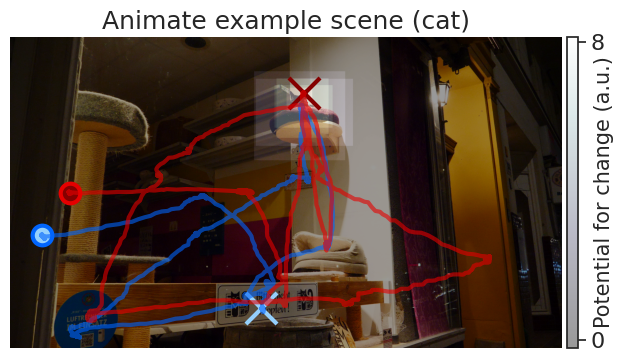

In [10]:
plot_qualitative_on_scene("catcafe", "01", "Animate example scene (cat)", maxpfa=8, inc_cbartext=True, dpi=100) # set dpi higher for paper quality!

## Quantitative analysis

The intuition provided by the qualitative examples is confirmed in a quantitative analysis of all scanpaths of the 20 observers on the 80 different scenes. 

In [11]:
def generate_res_dfs(condition, measure="pfa", nss_size="nss1.5dva", EVAL_PATH=EVAL_PATH):
    if condition == "animacy":
        conds = ["animate", "inanimate"]
    elif condition == "viewing_order":
        conds = ["unseen", "seen"]
    elif condition == "main_res":
        conds = ["pfa", "nss"]
    elif condition == "other_nss_sizes":
        conds = ["nss1dva", "nss2dva"]

    d_res = {
        conds[0]: {"vid": {}, "img": {}},
        conds[1]: {"vid": {}, "img": {}},
    }
    
    subj_ids = sorted([f[7:9] for f in os.listdir(EVAL_PATH) if "_all_hpc.csv.gz" in f])
    for s_id in tqdm(sorted(subj_ids)):
        df_eval = pd.read_csv(
            f"{EVAL_PATH}LPA_5s_{s_id}_eval_rad05_all_hpc.csv.gz", compression="gzip"
        )
        
        if condition == "animacy":
            (
                d_res["animate"]["vid"][s_id],
                d_res["animate"]["img"][s_id],
            ) = utils.avrg_measure_along_t(df_eval, measure, animate=True)
            (
                d_res["inanimate"]["vid"][s_id],
                d_res["inanimate"]["img"][s_id],
            ) = utils.avrg_measure_along_t(df_eval, measure, inanimate=True)

        elif condition == "viewing_order":
            (
                d_res["unseen"]["vid"][s_id],
                d_res["unseen"]["img"][s_id],
            ) = utils.avrg_measure_along_t(df_eval, measure, unseen=True)
            (
                d_res["seen"]["vid"][s_id],
                d_res["seen"]["img"][s_id],
            ) = utils.avrg_measure_along_t(df_eval, measure, seen=True)
        
        elif condition == "main_res":
            (
                d_res["pfa"]["vid"][s_id],
                d_res["pfa"]["img"][s_id],
            ) = utils.avrg_measure_along_t(df_eval, "pfa")
            (
                d_res["nss"]["vid"][s_id],
                d_res["nss"]["img"][s_id],
            ) = utils.avrg_measure_along_t(df_eval, nss_size)

        elif condition == "other_nss_sizes":
            (
                d_res["nss1dva"]["vid"][s_id],
                d_res["nss1dva"]["img"][s_id],
            ) = utils.avrg_measure_along_t(df_eval, "nss1dva")
            (
                d_res["nss2dva"]["vid"][s_id],
                d_res["nss2dva"]["img"][s_id],
            ) = utils.avrg_measure_along_t(df_eval, "nss2dva")

    # convert results to pandas dataframe for easier handling
    for cond in conds:
        for mode in ["vid", "img"]:
            d_res[cond][mode] = pd.DataFrame(d_res[cond][mode]).T

    return d_res


In [12]:
main_res = generate_res_dfs(condition="main_res")
sig_cluster_pfa = utils.cluster_based_permutation_test(main_res["pfa"]["vid"], main_res["pfa"]["img"])
sig_cluster_nss = utils.cluster_based_permutation_test(main_res["nss"]["vid"], main_res["nss"]["img"])

100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


#clusters over thres. (1073.3724818585874): 1
#clusters over thres. (857.0171602775815): 2


First, lets have a look at the results we expected when writing the preregistration for this experiment, which is documented in the [Data Analysis](https://osf.io/5anec/wiki/home/) section of the preregistration and quantifies the described [Hypotheses](https://osf.io/ps5y7/wiki/home/).

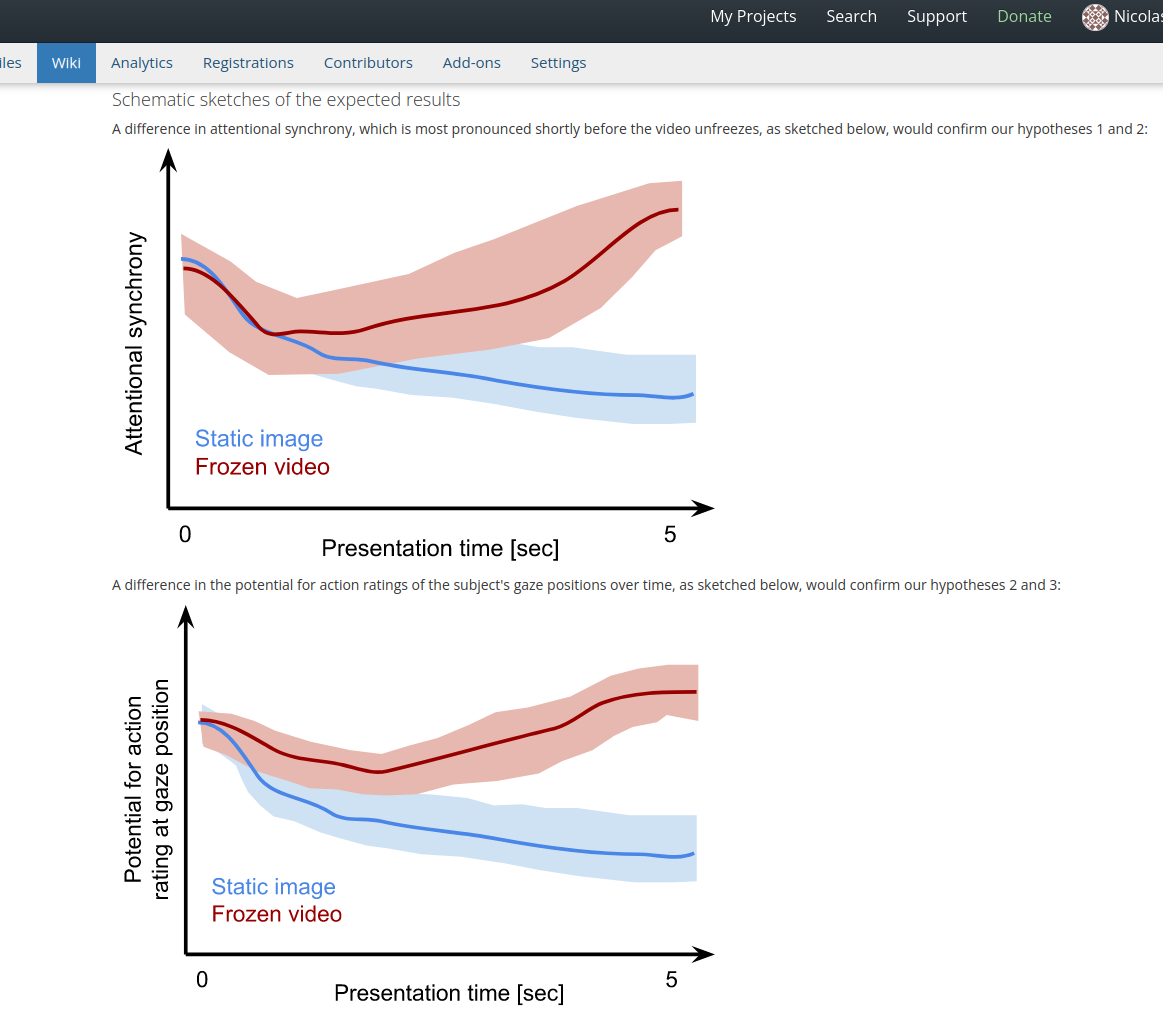

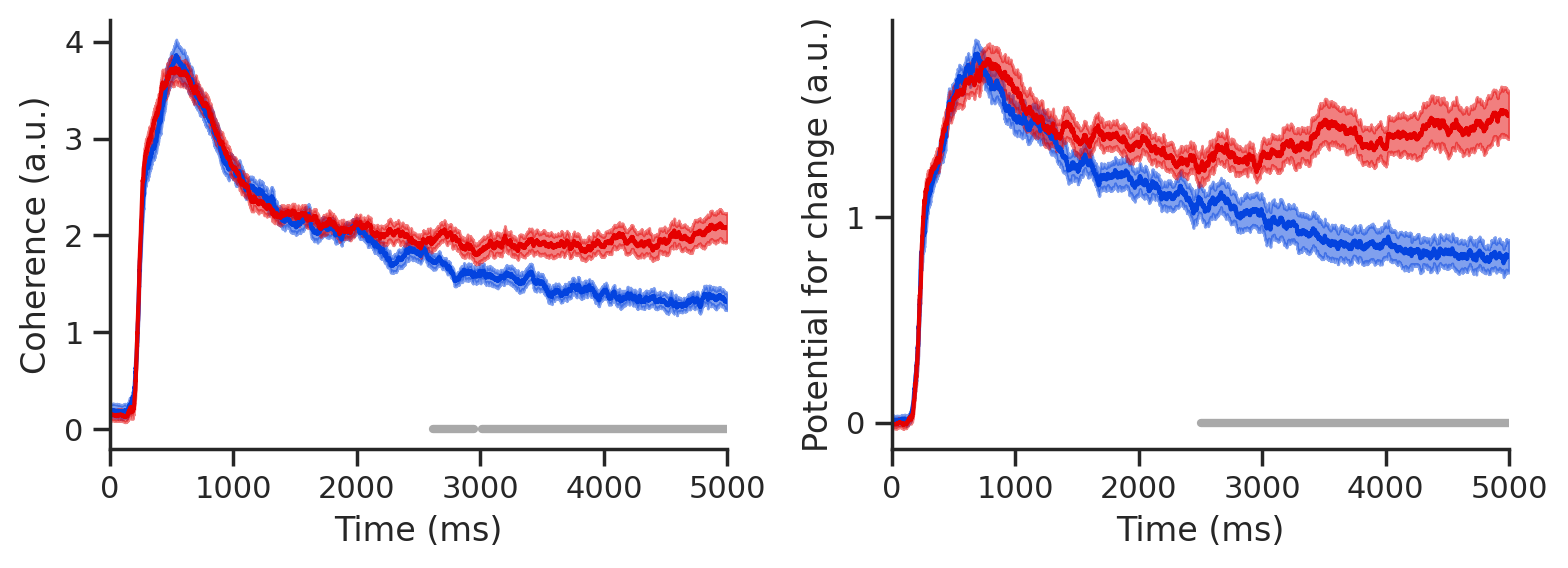

In [13]:
fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=200)

utils.plot_img_vs_vid(main_res, "nss", axs[0], ylabel="Coherence (a.u.)")
for i in range(len(sig_cluster_nss)):
    axs[0].plot([sig_cluster_nss.iloc[i].cluster_location[0].min(), sig_cluster_nss.iloc[i].cluster_location[0].max()], [0, 0], lw=3, color='darkgray')

utils.plot_img_vs_vid(main_res, "pfa", axs[1], ylabel="Potential for change (a.u.)")
axs[1].plot([sig_cluster_pfa.iloc[0].cluster_location[0].min(), sig_cluster_pfa.iloc[0].cluster_location[0].max()], [0, 0], lw=3, color='darkgray')

sns.despine(fig)
plt.tight_layout()


In [14]:
print(f"The maximum NSS for images is reached at {main_res['nss']['img'].mean().idxmax()} s, and for videos at {main_res['nss']['vid'].mean().idxmax()} s.")
print(f"NSS is first significant after {sig_cluster_nss.iloc[0].cluster_location[0].min()} ms")

print(f"The maximum PFA for images is reached at {main_res['pfa']['img'].mean().idxmax()} s, and for videos at {main_res['pfa']['vid'].mean().idxmax()} s.")
print(f"The maximum PFA for images is {main_res['pfa']['img'].mean().max()} s, and for videos at {main_res['pfa']['vid'].mean().max()} s.")
print(f"PfA is first significant after {sig_cluster_pfa.iloc[0].cluster_location[0].min()} ms")

The maximum NSS for images is reached at 537 s, and for videos at 531 s.
NSS is first significant after 2613 ms
The maximum PFA for images is reached at 692 s, and for videos at 772 s.
The maximum PFA for images is 1.7987678672046492 s, and for videos at 1.7720555025013862 s.
PfA is first significant after 2503 ms


#### For comparison, we also calculate the coherence for different kernel sizes (1dva and 2dva, default is 1.5dva)
This figure is not in the manuscript, but we include it here for completeness. It shows that the results are robust to the choice of kernel size.

100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


#clusters over thres. (790.7045505623182): 2
#clusters over thres. (928.4363153537403): 1
The maximum NSS1dva for images is reached at 537 s, and for videos at 558 s.
The maximum NSS2dva for images is reached at 537 s, and for videos at 531 s.


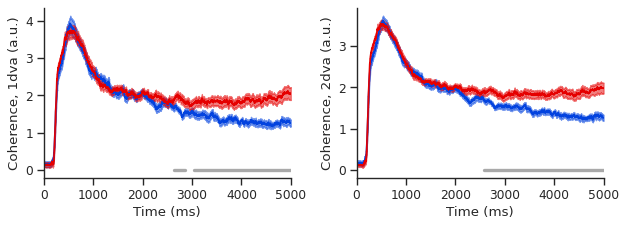

In [13]:
res_nss_sizes = generate_res_dfs(condition="other_nss_sizes")
sig_cluster_1dva = utils.cluster_based_permutation_test(res_nss_sizes["nss1dva"]["vid"], res_nss_sizes["nss1dva"]["img"])
sig_cluster_2dva = utils.cluster_based_permutation_test(res_nss_sizes["nss2dva"]["vid"], res_nss_sizes["nss2dva"]["img"])

fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=80)
utils.plot_img_vs_vid(res_nss_sizes, "nss1dva", axs[0], ylabel="Coherence, 1dva (a.u.)")
for i in range(len(sig_cluster_1dva)):
    axs[0].plot([sig_cluster_1dva.iloc[i].cluster_location[0].min(), sig_cluster_1dva.iloc[i].cluster_location[0].max()], [0, 0], lw=3, color='darkgray')
utils.plot_img_vs_vid(res_nss_sizes, "nss2dva", axs[1], ylabel="Coherence, 2dva (a.u.)")
axs[1].plot([sig_cluster_2dva.iloc[0].cluster_location[0].min(), sig_cluster_2dva.iloc[0].cluster_location[0].max()], [0, 0], lw=3, color='darkgray')
sns.despine(fig)
plt.tight_layout()
print(f"The maximum NSS1dva for images is reached at {res_nss_sizes['nss1dva']['img'].mean().idxmax()} s, and for videos at {res_nss_sizes['nss1dva']['vid'].mean().idxmax()} s.")
print(f"The maximum NSS2dva for images is reached at {res_nss_sizes['nss2dva']['img'].mean().idxmax()} s, and for videos at {res_nss_sizes['nss2dva']['vid'].mean().idxmax()} s.")

## Animacy and saliency

In [14]:
ani_pfa_res = generate_res_dfs(condition="animacy", measure="pfa")
sig_cluster_pfa_ani = utils.cluster_based_permutation_test(ani_pfa_res["animate"]["vid"], ani_pfa_res["animate"]["img"])
sig_cluster_pfa_inani = utils.cluster_based_permutation_test(ani_pfa_res["inanimate"]["vid"], ani_pfa_res["inanimate"]["img"])
ani_sal_res = generate_res_dfs(condition="animacy", measure="sal")
sig_cluster_sal_ani = utils.cluster_based_permutation_test(ani_sal_res["animate"]["vid"], ani_sal_res["animate"]["img"])
sig_cluster_sal_inani = utils.cluster_based_permutation_test(ani_sal_res["inanimate"]["vid"], ani_sal_res["inanimate"]["img"])
ani_saltb_res = generate_res_dfs(condition="animacy", measure="sal_tb")
sig_cluster_saltb_ani = utils.cluster_based_permutation_test(ani_saltb_res["animate"]["vid"], ani_saltb_res["animate"]["img"])
sig_cluster_saltb_inani = utils.cluster_based_permutation_test(ani_saltb_res["inanimate"]["vid"], ani_saltb_res["inanimate"]["img"])

100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


#clusters over thres. (1115.180770234385): 1
#clusters over thres. (803.4791151847837): 3


100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


#clusters over thres. (931.1363155664487): 4
#clusters over thres. (837.8120816133039): 0


100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


#clusters over thres. (749.8205415561191): 0
#clusters over thres. (697.1449627012646): 0


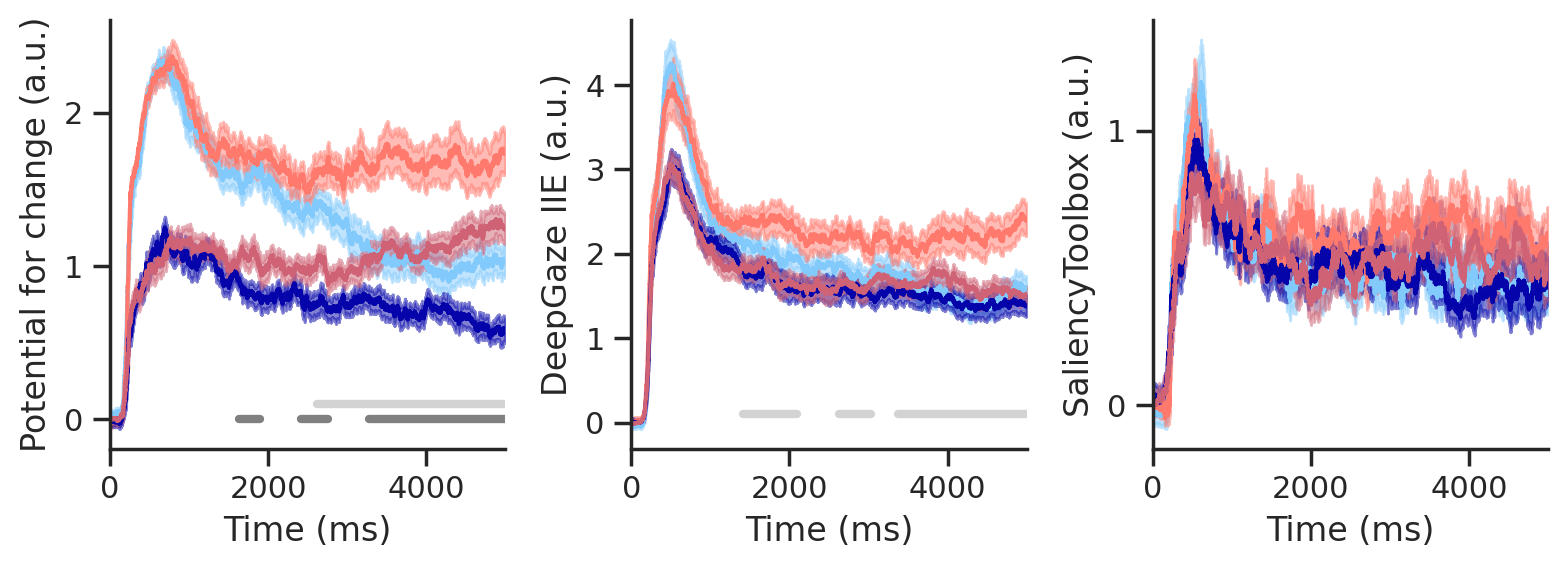

In [15]:
fig, axs = plt.subplots(1,3, figsize=(8,3), dpi=200)
utils.plot_img_vs_vid(ani_pfa_res, "animate", axs[0], img_color="xkcd:sky", vid_color="xkcd:salmon", ylabel="Potential for change (a.u.)")
utils.plot_img_vs_vid(ani_pfa_res, "inanimate", axs[0], img_color="xkcd:royal blue", vid_color="xkcd:rose", ylabel="Potential for change (a.u.)")
axs[0].plot([sig_cluster_pfa_ani.iloc[0].cluster_location[0].min(), sig_cluster_pfa_ani.iloc[0].cluster_location[0].max()], [0.1, 0.1], lw=3, color='lightgray')
for i in range(len(sig_cluster_pfa_inani)):
    axs[0].plot([sig_cluster_pfa_inani.iloc[i].cluster_location[0].min(), sig_cluster_pfa_inani.iloc[i].cluster_location[0].max()], [0, 0], lw=3, color='gray')

utils.plot_img_vs_vid(ani_sal_res, "animate", axs[1], img_color="xkcd:sky", vid_color="xkcd:salmon", ylabel="DeepGaze IIE (a.u.)")
utils.plot_img_vs_vid(ani_sal_res, "inanimate", axs[1], img_color="xkcd:royal blue", vid_color="xkcd:rose", ylabel="DeepGaze IIE (a.u.)")
for i in range(len(sig_cluster_sal_ani)):
    axs[1].plot([sig_cluster_sal_ani.iloc[i].cluster_location[0].min(), sig_cluster_sal_ani.iloc[i].cluster_location[0].max()], [0.1, 0.1], lw=3, color='lightgray')

utils.plot_img_vs_vid(ani_saltb_res, "animate", axs[2], img_color="xkcd:sky", vid_color="xkcd:salmon", ylabel="SaliencyToolbox (a.u.)")
utils.plot_img_vs_vid(ani_saltb_res, "inanimate", axs[2], img_color="xkcd:royal blue", vid_color="xkcd:rose", ylabel="SaliencyToolbox (a.u.)")

sns.despine(fig)
plt.tight_layout()
plt.show()

In [16]:
df_ani = pd.DataFrame({
    'PfA': np.concatenate([ani_pfa_res['animate']['vid'].values.sum(axis=1), ani_pfa_res['animate']['img'].values.sum(axis=1),
                            ani_pfa_res['inanimate']['vid'].values.sum(axis=1), ani_pfa_res['inanimate']['img'].values.sum(axis=1)]),
    'Sal': np.concatenate([ani_sal_res['animate']['vid'].values.sum(axis=1), ani_sal_res['animate']['img'].values.sum(axis=1),
                            ani_sal_res['inanimate']['vid'].values.sum(axis=1), ani_sal_res['inanimate']['img'].values.sum(axis=1)]),
    'Video': np.concatenate([np.ones(len(ani_pfa_res['animate']['vid'])), np.zeros(len(ani_pfa_res['animate']['img'])),
                              np.ones(len(ani_pfa_res['inanimate']['vid'])), np.zeros(len(ani_pfa_res['inanimate']['img']))]),
    'Animate': np.concatenate([np.ones(len(ani_pfa_res['animate']['vid'])), np.ones(len(ani_pfa_res['animate']['img'])),
                                np.zeros(len(ani_pfa_res['inanimate']['vid'])), np.zeros(len(ani_pfa_res['inanimate']['img']))])
})
df_ani


PfA           Sal  Video  Animate
0   8961.517766  14179.713660    1.0      1.0
1   8632.827795  13440.000775    1.0      1.0
2   8395.183943  15726.733531    1.0      1.0
3   5875.416163   7992.589439    1.0      1.0
4   8616.308536  13154.497980    1.0      1.0
..          ...           ...    ...      ...
75  3646.309072   6280.519127    0.0      0.0
76  3377.439207   8196.779431    0.0      0.0
77  4849.046495   9481.822528    0.0      0.0
78  3597.472391   8446.872069    0.0      0.0
79  4963.769194  12134.908065    0.0      0.0

[80 rows x 4 columns]

In [17]:
formula = 'PfA ~ C(Video) * C(Animate)'
model = ols(formula, data=df_ani).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                           sum_sq    df           F        PR(>F)
C(Video)             4.122855e+07   1.0   23.204854  7.270763e-06
C(Animate)           1.884904e+08   1.0  106.088929  4.504534e-16
C(Video):C(Animate)  9.536416e+05   1.0    0.536742  4.660395e-01
Residual             1.350308e+08  76.0         NaN           NaN


In [18]:
formula = 'Sal ~ C(Video) * C(Animate)'
model = ols(formula, data=df_ani).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                           sum_sq    df          F    PR(>F)
C(Video)             2.689886e+07   1.0   4.231648  0.043108
C(Animate)           8.905632e+07   1.0  14.010072  0.000351
C(Video):C(Animate)  1.259878e+07   1.0   1.982002  0.163257
Residual             4.831010e+08  76.0        NaN       NaN


## Object-based analysis

TOTAL FIX: slope = 211.78, intercept = -40.11, $p$-value = 1.407285984805253e-10, r2 = 0.14930267286615767
DETECTIONS: slope = 28.13, intercept = -4.36, $p$-value = 0.0007157317670129042, r2 = 0.043985001417455614
INSPECTIONS: slope = 142.96, intercept = -52.02, $p$-value = 8.268845299609174e-08, r2 = 0.1067895655520487
RETURNS: slope = 40.69, intercept = 16.27, $p$-value = 0.0006858180356952263, r2 = 0.04428302317802198


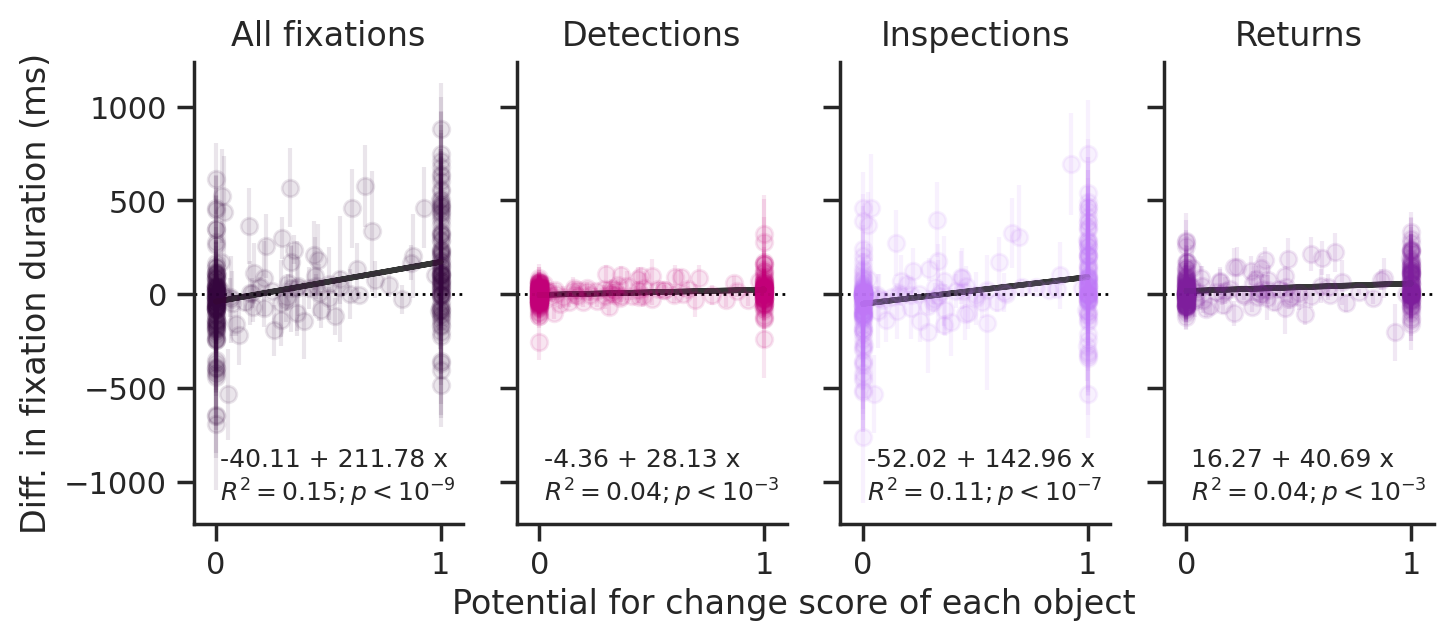

In [15]:
fig, axs = plt.subplots(1,4, figsize=(8,3), dpi=200, sharey=True)

df_dt_mean = df_obj_dt.groupby("scene_obj").mean().reset_index()
df_dt_sem = df_obj_dt.groupby("scene_obj").sem().reset_index()

axs[0].errorbar(df_obj.n_pfa, df_dt_mean["all"], yerr=df_dt_sem["all"], fmt='o', c="xkcd:dark purple", alpha=0.1)
axs[0].set_title("All fixations")
axs[0].set_ylabel("Diff. in fixation duration (ms)")
slope, intercept, r_value, p_value, std_err = stats.linregress(df_obj.n_pfa, df_dt_mean["all"])
axs[0].plot(df_obj.n_pfa, intercept + slope * df_obj.n_pfa, color='xkcd:dark gray',lw=2, ls="-")
axs[0].text(0.1, 0.05, f"{intercept:.2f} + {slope:.2f} x\n"+r"$R^2 = 0.15; p<10^{-9}$", transform=axs[0].transAxes, fontsize=9)
print(f"TOTAL FIX: slope = {slope:.2f}, intercept = {intercept:.2f}, $p$-value = {p_value}, r2 = {r_value**2}")

axs[1].errorbar(df_obj.n_pfa, df_dt_mean["D"], yerr=df_dt_sem["D"], fmt='o', c="xkcd:magenta", alpha=0.1)
axs[1].set_title("Detections")
slope, intercept, r_value, p_value, std_err = stats.linregress(df_obj.n_pfa, df_dt_mean["D"])
axs[1].plot(df_obj.n_pfa, intercept + slope * df_obj.n_pfa, color='xkcd:dark gray',lw=2, ls="-")
axs[1].text(0.1, 0.05, f"{intercept:.2f} + {slope:.2f} x\n"+r"$R^2 = 0.04; p<10^{-3}$", transform=axs[1].transAxes, fontsize=9)
print(f"DETECTIONS: slope = {slope:.2f}, intercept = {intercept:.2f}, $p$-value = {p_value}, r2 = {r_value**2}")

axs[2].errorbar(df_obj.n_pfa, df_dt_mean["I"], yerr=df_dt_sem["I"], fmt='o', c="xkcd:light purple", alpha=0.1)
axs[2].set_title("Inspections")
slope, intercept, r_value, p_value, std_err = stats.linregress(df_obj.n_pfa, df_dt_mean["I"])
axs[2].plot(df_obj.n_pfa, intercept + slope * df_obj.n_pfa, color='xkcd:dark gray',lw=2, ls="-")
axs[2].text(0.1, 0.05, f"{intercept:.2f} + {slope:.2f} x\n"+r"$R^2 = 0.11; p<10^{-7}$", transform=axs[2].transAxes, fontsize=9)
print(f"INSPECTIONS: slope = {slope:.2f}, intercept = {intercept:.2f}, $p$-value = {p_value}, r2 = {r_value**2}")

axs[3].errorbar(df_obj.n_pfa, df_dt_mean["R"], yerr=df_dt_sem["R"], fmt='o', c="xkcd:purple", alpha=0.1)
axs[3].set_title("Returns")
slope, intercept, r_value, p_value, std_err = stats.linregress(df_obj.n_pfa, df_dt_mean["R"])
axs[3].plot(df_obj.n_pfa, intercept + slope * df_obj.n_pfa, color='xkcd:dark gray',lw=2, ls="-")
axs[3].text(0.1, 0.05, f"{intercept:.2f} + {slope:.2f} x\n"+r"$R^2 = 0.04; p<10^{-3}$", transform=axs[3].transAxes, fontsize=9)
print(f"RETURNS: slope = {slope:.2f}, intercept = {intercept:.2f}, $p$-value = {p_value}, r2 = {r_value**2}")

for ax in axs:
    ax.axhline(y=0, color='black', linestyle=':', alpha=1, lw=1)
    ax.set_xlim(-0.1, 1.1)


fig.supxlabel('Potential for change score of each object', fontsize=12, y=-0.05)
# plt.tight_layout()
sns.despine()


In [16]:
print(df_dt_mean["I"].mean(), df_dt_mean["R"].mean())
df_obj.head()
df_dt_mean.head()

8.088326848249025 33.37412451361868


scene_obj  subj_id     all      D       I       R
0      axolotl_1    11.45   65.45 -55.35  104.95   15.85
1      axolotl_2    11.45  -78.00 -24.40   15.55  -69.15
2      axolotl_3    11.45    0.00  -2.60  -41.10   43.70
3  ballBalance_1    11.45  203.05  18.95  100.25   83.85
4  ballBalance_2    11.45   41.85 -26.95  -43.35  112.15

TOTAL FIX: slope = 74.61, intercept = 14.93, $p$-value = 0.037009136442489425, r2 = 0.01694697935074232
DETECTIONS: slope = 11.65, intercept = 2.16, $p$-value = 0.18444950298570303, r2 = 0.006897120634832864
INSPECTIONS: slope = 58.51, intercept = -18.58, $p$-value = 0.040470041066602, r2 = 0.01635998039729535
RETURNS: slope = 4.45, intercept = 31.35, $p$-value = 0.7254478870307521, r2 = 0.0004844885906627102


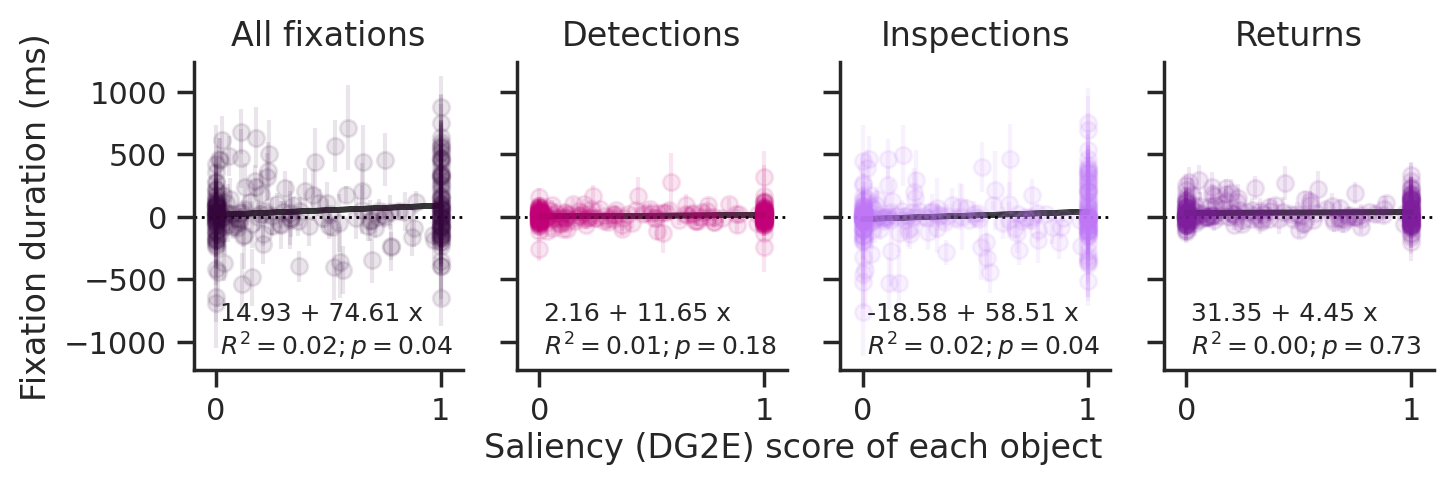

In [29]:
fig, axs = plt.subplots(1,4, figsize=(8,2), dpi=200, sharey=True)

df_dt_mean = df_obj_dt.groupby("scene_obj").mean().reset_index()
df_dt_sem = df_obj_dt.groupby("scene_obj").sem().reset_index()

axs[0].errorbar(df_obj.n_sal_dg, df_dt_mean["all"], yerr=df_dt_sem["all"], fmt='o', c="xkcd:dark purple", alpha=0.1)
axs[0].set_title("All fixations")
axs[0].set_ylabel("Fixation duration (ms)")
slope, intercept, r_value, p_value, std_err = stats.linregress(df_obj.n_sal_dg, df_dt_mean["all"])
axs[0].plot(df_obj.n_sal_dg, intercept + slope * df_obj.n_sal_dg, color='xkcd:dark gray',lw=2, ls="-")
axs[0].text(0.1, 0.05, f"{intercept:.2f} + {slope:.2f} x\n"+r"$R^2 = 0.02; p=0.04$", transform=axs[0].transAxes, fontsize=9)
print(f"TOTAL FIX: slope = {slope:.2f}, intercept = {intercept:.2f}, $p$-value = {p_value}, r2 = {r_value**2}")

axs[1].errorbar(df_obj.n_sal_dg, df_dt_mean["D"], yerr=df_dt_sem["D"], fmt='o', c="xkcd:magenta", alpha=0.1)
axs[1].set_title("Detections")
slope, intercept, r_value, p_value, std_err = stats.linregress(df_obj.n_sal_dg, df_dt_mean["D"])
axs[1].plot(df_obj.n_sal_dg, intercept + slope * df_obj.n_sal_dg, color='xkcd:dark gray',lw=2, ls="-")
axs[1].text(0.1, 0.05, f"{intercept:.2f} + {slope:.2f} x\n"+r"$R^2 = 0.01; p=0.18$", transform=axs[1].transAxes, fontsize=9)
print(f"DETECTIONS: slope = {slope:.2f}, intercept = {intercept:.2f}, $p$-value = {p_value}, r2 = {r_value**2}")

axs[2].errorbar(df_obj.n_sal_dg, df_dt_mean["I"], yerr=df_dt_sem["I"], fmt='o', c="xkcd:light purple", alpha=0.1)
axs[2].set_title("Inspections")
slope, intercept, r_value, p_value, std_err = stats.linregress(df_obj.n_sal_dg, df_dt_mean["I"])
axs[2].plot(df_obj.n_sal_dg, intercept + slope * df_obj.n_sal_dg, color='xkcd:dark gray',lw=2, ls="-")
axs[2].text(0.1, 0.05, f"{intercept:.2f} + {slope:.2f} x\n"+r"$R^2 = 0.02; p=0.04$", transform=axs[2].transAxes, fontsize=9)
print(f"INSPECTIONS: slope = {slope:.2f}, intercept = {intercept:.2f}, $p$-value = {p_value}, r2 = {r_value**2}")

axs[3].errorbar(df_obj.n_sal_dg, df_dt_mean["R"], yerr=df_dt_sem["R"], fmt='o', c="xkcd:purple", alpha=0.1)
axs[3].set_title("Returns")
slope, intercept, r_value, p_value, std_err = stats.linregress(df_obj.n_sal_dg, df_dt_mean["R"])
axs[3].plot(df_obj.n_sal_dg, intercept + slope * df_obj.n_sal_dg, color='xkcd:dark gray',lw=2, ls="-")
axs[3].text(0.1, 0.05, f"{intercept:.2f} + {slope:.2f} x\n"+r"$R^2 = 0.00; p=0.73$", transform=axs[3].transAxes, fontsize=9)
print(f"RETURNS: slope = {slope:.2f}, intercept = {intercept:.2f}, $p$-value = {p_value}, r2 = {r_value**2}")

for ax in axs:
    ax.axhline(y=0, color='black', linestyle=':', alpha=1, lw=1)
    ax.set_xlim(-0.1, 1.1)


fig.supxlabel('Saliency (DG2E) score of each object', fontsize=12, y=-0.125)
# plt.tight_layout()
sns.despine()


## Supplement: Rater consistency

In [11]:
def calculate_iou(box1, box2):
    # Intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    # Union area
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    
    union_area = box1_area + box2_area - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area
    
    return iou

def get_mean_iou_and_zero_overlap(df_pfa, scene):
    df_temp = df_pfa[df_pfa["scene"] == scene]
    label_boxes = []
    for i in range(len(df_temp)):
        box = np.array([int(df_temp.iloc[i][1]), int(df_temp.iloc[i][2]), int(df_temp.iloc[i][1])+int(df_temp.iloc[i][3]), int(df_temp.iloc[i][2])+int(df_temp.iloc[i][4])])
        label_boxes.append(box)
    iou_matrix = np.zeros((len(label_boxes), len(label_boxes)))
    for i in range(len(label_boxes)):
        for j in range(len(label_boxes)):
            iou_matrix[i, j] = calculate_iou(label_boxes[i], label_boxes[j])
    mean_iou = iou_matrix[np.triu_indices(len(label_boxes), k=1)].mean()
    zero_overlap = np.sum(iou_matrix == 0) / (len(label_boxes) * (len(label_boxes) - 1))
    return mean_iou, zero_overlap


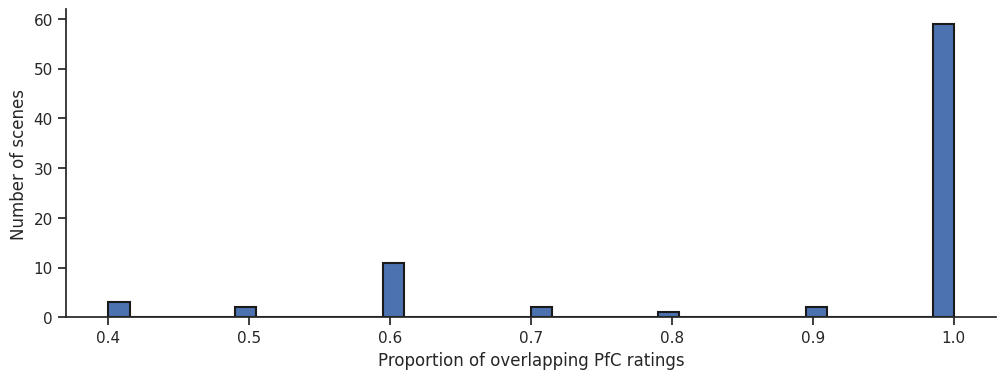

In [19]:
iou_data = {}
for scene in sorted(df_all.scene.unique()):
    iou_data[scene] = get_mean_iou_and_zero_overlap(DF_PFA, scene)
iou_df = pd.DataFrame(iou_data).T
iou_df.columns = ["mean_iou", "zero_overlap"]
# iou_df.sort_values("mean_iou", ascending=False)

plt.figure(figsize=(12, 4))
plt.hist(1-iou_df["zero_overlap"], bins=40, edgecolor="k", linewidth=1.5)
plt.xlabel("Proportion of overlapping PfC ratings")
plt.ylabel("Number of scenes")
sns.despine(); plt.show()

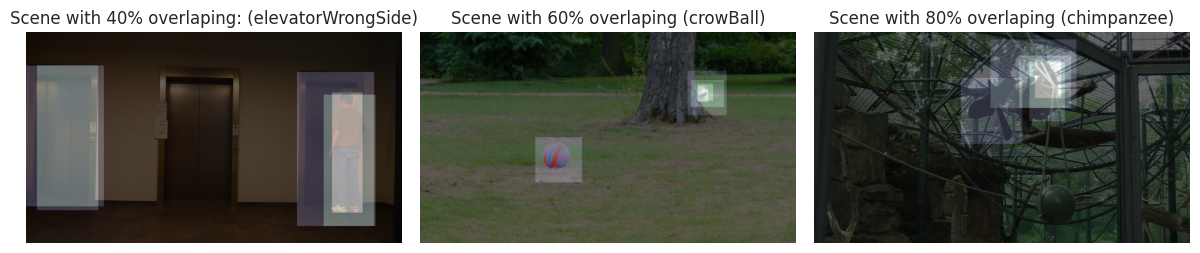

In [20]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
scene = "elevatorWrongSide"
im = plt.imread(os.path.join(IMG_PATH, f"{scene}.png"))
axs[0].imshow(im)
axs[0].imshow(em.get_potential_for_action(DF_PFA, scene), cmap="bone", alpha=0.6)
iou_val = round(iou_df.loc[scene, "mean_iou"], 2)
axs[0].set_title(f"Scene with 40% overlaping: ({scene})")

scene = "crowBall"
im = plt.imread(os.path.join(IMG_PATH, f"{scene}.png"))
axs[1].imshow(im)
axs[1].imshow(em.get_potential_for_action(DF_PFA, scene), cmap="bone", alpha=0.6)
iou_val = round(iou_df.loc[scene, "mean_iou"], 2)
axs[1].set_title(f"Scene with 60% overlaping ({scene})")

scene = "chimpanzee"
im = plt.imread(os.path.join(IMG_PATH, f"{scene}.png"))
axs[2].imshow(im)
axs[2].imshow(em.get_potential_for_action(DF_PFA, scene), cmap="bone", alpha=0.6)
iou_val = round(iou_df.loc[scene, "mean_iou"], 2)
axs[2].set_title(f"Scene with 80% overlaping ({scene})")

for ax in axs:
    ax.axis("off")  
plt.tight_layout()

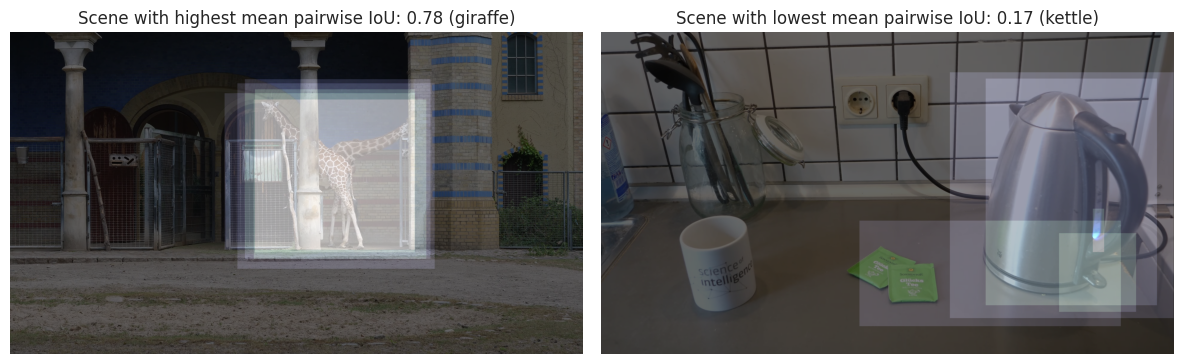

In [21]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
scene = "giraffe"
im = plt.imread(os.path.join(IMG_PATH, f"{scene}.png"))
axs[0].imshow(im)
axs[0].imshow(em.get_potential_for_action(DF_PFA, scene), cmap="bone", alpha=0.6)
iou_val = round(iou_df.loc[scene, "mean_iou"], 2)
axs[0].set_title(f"Scene with highest mean pairwise IoU: {iou_val} ({scene})")

scene = "kettle"
im = plt.imread(os.path.join(IMG_PATH, f"{scene}.png"))
axs[1].imshow(im)
axs[1].imshow(em.get_potential_for_action(DF_PFA, scene), cmap="bone", alpha=0.6)
iou_val = round(iou_df.loc[scene, "mean_iou"], 2)
axs[1].set_title(f"Scene with lowest mean pairwise IoU: {iou_val} ({scene})")

for ax in axs:
    ax.axis("off")  
plt.tight_layout()

## Supplement: Viewing order

In [19]:
order_pfa_res = generate_res_dfs(condition="viewing_order", measure="pfa")
sig_cluster_pfa_1st = utils.cluster_based_permutation_test(order_pfa_res["unseen"]["vid"], order_pfa_res["unseen"]["img"])
sig_cluster_pfa_2nd = utils.cluster_based_permutation_test(order_pfa_res["seen"]["vid"], order_pfa_res["seen"]["img"])

100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


#clusters over thres. (1072.2935117939385): 1
#clusters over thres. (988.8261061139322): 2


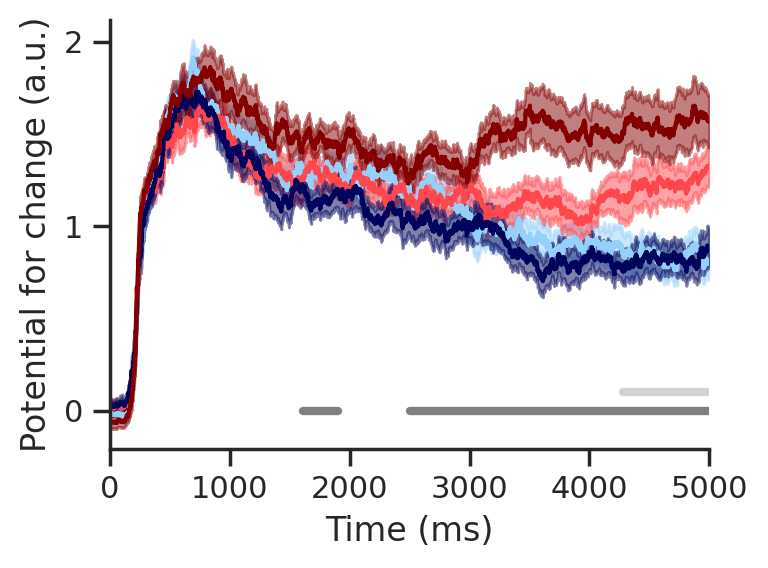

In [20]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
utils.plot_img_vs_vid(order_pfa_res, "unseen", ax, img_color="xkcd:light blue", vid_color="xkcd:light red", ylabel="Potential for change (a.u.)")
utils.plot_img_vs_vid(order_pfa_res, "seen", ax, img_color="xkcd:dark blue", vid_color="xkcd:dark red", ylabel="Potential for change (a.u.)")
ax.plot([sig_cluster_pfa_1st.iloc[0].cluster_location[0].min(), sig_cluster_pfa_1st.iloc[0].cluster_location[0].max()], [0.1, 0.1], lw=3, color='lightgray')
for i in range(len(sig_cluster_pfa_2nd)):
    ax.plot([sig_cluster_pfa_2nd.iloc[i].cluster_location[0].min(), sig_cluster_pfa_2nd.iloc[i].cluster_location[0].max()], [0, 0], lw=3, color='gray')

sns.despine(fig)
plt.tight_layout()
plt.show()

## Supplement: Example scenes

Olga /home/nico/project_data/LPA/ExpertRatings/Olga_ratings.csv
Lynn /home/nico/project_data/LPA/ExpertRatings/Lynn_ratings.csv
Angelica /home/nico/project_data/LPA/ExpertRatings/Angelica_ratings.csv
Vito /home/nico/project_data/LPA/ExpertRatings/Vito_ratings.csv
Robert /home/nico/project_data/LPA/ExpertRatings/Robert_ratings.csv


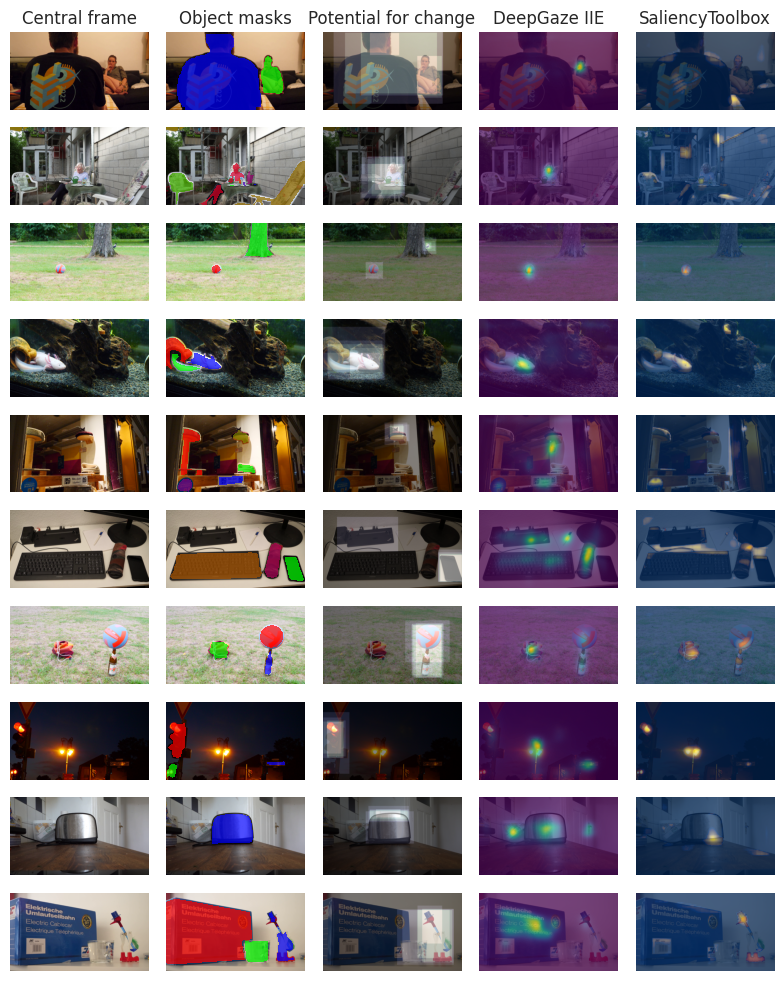

In [26]:
# To reproduce this plot in colab, additional data has to be downloaded

if RUN_LOCALLY:
    SAL_PATH = "/home/nico/project_code/LPA_study/Saliency/"
    OBJ_PATH = "/home/nico/project_code/LPA_study/Segmentation/"
    DF_PFA = em.create_expert_df("/home/nico/project_data/LPA/ExpertRatings/")

    fig, axs = plt.subplots(10,5, figsize=(8,10), dpi=100) # dpi=400 for paper

    for i, scene in enumerate(["conversation", "watering", "crowBall", "axolotl", "catcafe", "phone", "ballBalance", "trafficLight2", "toaster", "trinkvogel2"]):
        im_path = f"/home/nico/project_code/LPA_study/Stimuli/{scene}.png"
        im = plt.imread(im_path)
        pfa = em.get_potential_for_action(DF_PFA, scene)
        sal = em.get_saliency_dg(path=SAL_PATH, scene=scene)
        sal_tb = em.get_saliency_tb(path=SAL_PATH, scene=scene)
        obj = np.load(OBJ_PATH + scene + ".npy").astype(float)
        obj[obj==0] = np.nan

        # alphas = [1,0.5, 1,1,1]
        for j in range(5):
            axs[i,j].imshow(im) #, alpha=alphas[j])
        s = axs[i,1].imshow(obj, alpha=0.7, cmap="brg")  # plasma
        p = axs[i,2].imshow(pfa, alpha=0.5, cmap="bone")  # plasma
        d = axs[i,3].imshow(sal, alpha=0.7, cmap="viridis")  # plasma
        s = axs[i,4].imshow(sal_tb, alpha=0.7, cmap="cividis")  # plasma

    for ax in axs.flatten():
        ax.axis("off")

    axs[0,0].set_title("Central frame") #, fontsize=18)
    axs[0,1].set_title("Object masks") #, fontsize=18)
    axs[0,2].set_title("Potential for change") #, fontsize=18)
    axs[0,3].set_title("DeepGaze IIE") #, fontsize=18)
    axs[0,4].set_title("SaliencyToolbox") #, fontsize=18)

    plt.tight_layout()
    plt.show()
else:
    print("This plot is for visualizing of the different scenes and their annotations. It can only be reproduced locally or by downloading additional stimuli and the corresponding object masks and saliency computations the colab environment.")

## Supplement: Correlation of saliency and potential for change

In [27]:
d_animate = {"axolotl": 1, "ballBalance": 0, "bed": 0, "bench": 1, "bigAnimalBackground": 1, "bikeUnlocking": 1, "billboard": 0, "bird": 1, "birdFalling": 0, "blueBoiler": 0, "bottleString": 0, "candle": 0, "carStart": 0, "catcafe": 1, "chessBoard": 1, "chimpanzee": 1, "clock": 0, "coffeeOnSofa": 1, "construction": 1, "conversation": 1, "crow": 1, "crowBall": 1, "dino": 0, "disinfectant": 0, "elevatorEmpty": 0, "elevatorWrongSide": 1, "espresso": 0, "fingerTapping": 1, "fish": 1, "fly": 1, "giraffe": 1, "gondolaUp": 0, "heron": 1, "kettle": 0, "lake": 1, "laundry": 0, "lizard": 1, "mail": 1, "mokaPot": 0, "monitorLizard": 1, "monkey2": 1, "openDoorInside": 0, "openDoorOutside": 1, "pedestrian": 1, "penDrawing": 0, "phone": 0, "plank": 1, "receipt": 0, "reindeers": 1, "rippingPaper": 0, "robot": 0, "robot2": 1, "sealion": 0, "selfie": 1, "shoebill": 1, "shoot": 1, "skiLift": 0, "snip": 0, "sparkling2": 0, "stapler": 0, "statues": 1, "teabagOut": 0, "throw": 1, "toaster": 0, "toytrain": 0, "toytrainHouses": 0, "trafficLight": 0, "trafficLight2": 0, "trash": 1, "trinkvogel2": 0, "ventilator": 0, "waterHose": 0, "waterbottle": 0, "watercooler": 0, "watering": 1, "whiteBoard": 0, "work": 1, "work2": 1, "yoga": 1, "youtube": 1,}
scenes = sorted(d_animate.keys())

if RUN_LOCALLY:
    d_corr = {}
    for scene in scenes:
        pfa = em.get_potential_for_action(DF_PFA, scene)
        sal = em.get_saliency_dg(path=SAL_PATH, scene=scene)
        sal_tb = em.get_saliency_tb(path=SAL_PATH, scene=scene)
        sal_saltb_r, p_value = pearsonr(sal.flatten(), sal_tb.flatten())
        sal_pfa_r, p_value = pearsonr(sal.flatten(), pfa.flatten())
        saltb_pfa_r, p_value = pearsonr(sal_tb.flatten(), pfa.flatten())
        d_corr[scene] = {'sal_saltb_r': sal_saltb_r, 'sal_pfa_r': sal_pfa_r, 'saltb_pfa_r': saltb_pfa_r, "animate": d_animate[scene]}
        # print(f"{scene}, R: {correlation_coefficient}, p-value: {p_value}")
    df_corr = pd.DataFrame(d_corr).T
    df_corr

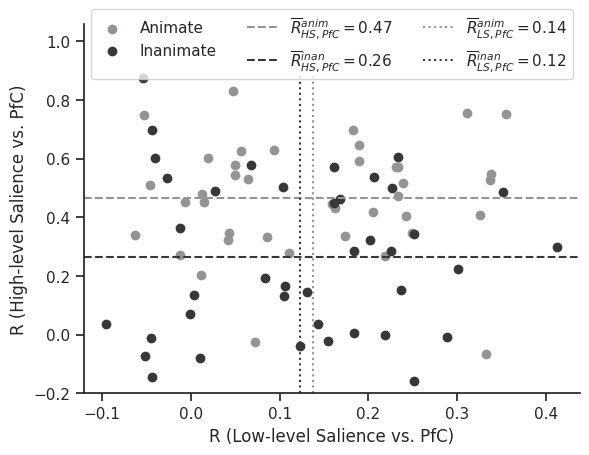

In [28]:
if RUN_LOCALLY:
    df_c_animates = df_corr[df_corr.animate==1]
    df_c_inanimates = df_corr[df_corr.animate==0]
    dpi = 100  # 300 for paper
    plt.figure(dpi=dpi)
    plt.scatter(df_c_animates.saltb_pfa_r.values, df_c_animates.sal_pfa_r.values, label="Animate", color='xkcd:gray', ) 
    plt.scatter(df_c_inanimates.saltb_pfa_r.values, df_c_inanimates.sal_pfa_r.values, label="Inanimate", color='xkcd:dark gray')
    plt.ylim(-0.2, 1.06)
    plt.axhline(df_c_animates.sal_pfa_r.mean(), linestyle='--', label=r"$\overline{R}_{HS,PfC}^{anim}=$" + str(round(df_c_animates.sal_pfa_r.mean(),2)), color='xkcd:gray')
    plt.axhline(df_c_inanimates.sal_pfa_r.mean(), linestyle='--', label=r"$\overline{R}_{HS,PfC}^{inan}=$" + str(round(df_c_inanimates.sal_pfa_r.mean(),2)), color='xkcd:dark gray')
    plt.axvline(df_c_animates.saltb_pfa_r.mean(), linestyle=':', label=r"$\overline{R}_{LS,PfC}^{anim}=$" + str(round(df_c_animates.saltb_pfa_r.mean(),2)), ymax=0.86, color='xkcd:gray')
    plt.axvline(df_c_inanimates.saltb_pfa_r.mean(), linestyle=':', label=r"$\overline{R}_{LS,PfC}^{inan}=$" + str(round(df_c_inanimates.saltb_pfa_r.mean(),2)), ymax=0.86, color='xkcd:dark gray')
    plt.xlabel('R (Low-level Salience vs. PfC)')
    plt.ylabel('R (High-level Salience vs. PfC)')
    plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.06), frameon=True)
    sns.despine()
    # save as pdf with 300 PPI
    plt.savefig("sal_pfa_corr.pdf", dpi=dpi, bbox_inches='tight') 
    plt.show()
else:
    print("This plot is for visualizing the correlation of PfC with salience depending on the animacy of the scene. It can only be reproduced locally or by downloading all saliency computations into the colab environment.")

## Supplement: Attentional synchrony as additional coherence measure

In [22]:
from matplotlib.patches import Ellipse

def calculate_attentional_synchrony(gaze_positions, print=False):
    """
    Calculate the attentional synchrony based on the given gaze positions.
    
    Parameters:
    gaze_positions (ndarray): An array of shape (n, 2) where n is the number of gaze points,
                              and each row represents the (x, y) coordinates of a gaze point.
                              
    Returns:
    float: The radius of the Gaussian circle enclosing 68% of the gaze points.
    tuple: The mean gaze position.
    """
    # Calculate the mean gaze position
    mean_gaze_position = np.mean(gaze_positions, axis=0)
    
    # Calculate the covariance matrix of the gaze positions
    cov_matrix = np.cov(gaze_positions, rowvar=False)
    
    # Extract the eigenvalues of the covariance matrix
    eigenvalues, _ = np.linalg.eigh(cov_matrix)
    
    # The radius of the smallest circle enclosing 68% of the gaze points is the square root of the largest eigenvalue
    radius = np.sqrt(np.max(eigenvalues))
    if print:
        print(radius)
    
    return radius, mean_gaze_position

def plot_gaussian_on_gaze_positions(gaze_positions, image_size=(1920, 1080)):
    """
    Plot the gaze positions and overlay a Gaussian representing the attentional synchrony.
    
    Parameters:
    gaze_positions (ndarray): An array of shape (n, 2) where n is the number of gaze points,
                              and each row represents the (x, y) coordinates of a gaze point.
    image_size (tuple): The size of the image (width, height).
    """
    radius, mean_gaze_position = calculate_attentional_synchrony(gaze_positions)
    
    fig, ax = plt.subplots()
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])
    
    # Plot gaze positions
    ax.scatter(gaze_positions[:, 0], gaze_positions[:, 1], c='blue', label='Gaze Positions')
    
    # Plot Gaussian (circle) representing attentional synchrony
    circle = Ellipse(mean_gaze_position, width=2*radius, height=2*radius, edgecolor='red', facecolor='none', lw=2, label='Gaussian (68%)')
    ax.add_patch(circle)
    
    # Invert y-axis to match typical image coordinates
    ax.invert_yaxis()
    ax.set_aspect("equal")

    ax.legend()
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Gaze Positions and Attentional Synchrony Gaussian')
    plt.show()

def get_gaze_for_scene_tbin(df, scene, t_start, t_end):
    df_scene_tbin = df[(df["scene"] == scene) & (df["t"].between(t_start, t_end))]
    x_positions = np.array(df_scene_tbin["x"])
    y_positions = np.array(df_scene_tbin["y"])

    return np.array([x_positions, y_positions]).T


In [ ]:
d_xyt_img = {}
d_xyt_vid = {}

for subject_id in subj_ids:
    df_eval = pd.read_csv(
        f"{EVAL_PATH}LPA_5s_{subject_id}_eval_rad05_all_hpc.csv.gz", compression="gzip"
    )
    df_eval = df_eval.dropna(subset=["x", "y", "t"])
    df_eval = df_eval[df_eval["em_rv"] == "FOV"]
    df_eval.drop(columns=["block", "trial_in_block", "seen", "animate", "em_rv", "sal_tb", "sal", "pfa", "obj", "nss1dva", "nss1.5dva", "nss2dva"], inplace=True)
    # drop non-finite values (NA or inf) in x, y, t
    # df_eval = df_eval.replace([np.inf, -np.inf], np.nan)
    df_eval["x"] = df_eval["x"].astype(int)
    df_eval["y"] = df_eval["y"].astype(int)
    df_sub_img = df_eval[df_eval["video"] == 0]
    df_sub_vid = df_eval[df_eval["video"] == 1]
    # add to dict
    d_xyt_img[subject_id] = df_sub_img
    d_xyt_vid[subject_id] = df_sub_vid
    # drop video column
    df_sub_img.drop(columns=["video"], inplace=True)
    df_sub_vid.drop(columns=["video"], inplace=True)
    # convert x and y to int

# convert dict to df
df_xyt_img = pd.concat(d_xyt_img.values())
df_xyt_vid = pd.concat(d_xyt_vid.values())

In [ ]:
# calculateing the attentional synchrony (i.e. fitting the Gaussian) for every time bin for every scene will take a while to run....
r_t_img = {}
r_t_vid = {}
for scene in df_xyt_img["scene"].unique():
    print(scene)
    r_t_img[scene] = []
    r_t_vid[scene] = []
    for t_start in range(0, 5000, 40):
        gaze_positions = get_gaze_for_scene_tbin(df_xyt_img, scene, t_start, t_start+40)
        r, _ = calculate_attentional_synchrony(gaze_positions)
        r_t_img[scene].append(r)
        gaze_positions = get_gaze_for_scene_tbin(df_xyt_vid, scene, t_start, t_start+40)
        r, _ = calculate_attentional_synchrony(gaze_positions)
        r_t_vid[scene].append(r)

# store in df
df_r_t_img = pd.DataFrame(r_t_img)
df_r_t_vid = pd.DataFrame(r_t_vid)
# save to csv, for convenience
if RUN_LOCALLY:
    df_r_t_img.to_csv(f"{EVAL_PATH}LPA_5s_r_t_img.csv", index=False)
    df_r_t_vid.to_csv(f"{EVAL_PATH}LPA_5s_r_t_vid.csv", index=False)

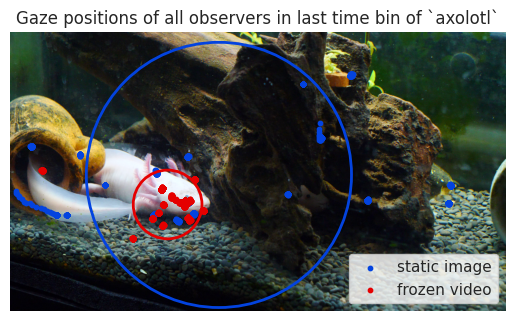

In [24]:
# plot last time bin of axolotl scene
scene = "axolotl"
img = plt.imread(f"{IMG_PATH}{scene}.png")
gaze_pos_img = get_gaze_for_scene_tbin(df_xyt_img, scene, 4960, 5000)
gaze_pos_vid = get_gaze_for_scene_tbin(df_xyt_vid, scene, 4960, 5000)

# plot gaze positions on image
fig, ax = plt.subplots(dpi=100) # more dpi for paper
ax.imshow(img) #, alpha=0.75)
ax.scatter(gaze_pos_img[:,0], gaze_pos_img[:,1], s=10, c="xkcd:blue", label="static image")
# plot_gaussian_on_gaze_positions(gaze_pos_img)
radius, mean_gaze_position = calculate_attentional_synchrony(gaze_pos_img)
circle = Ellipse(mean_gaze_position, width=2*radius, height=2*radius, edgecolor='xkcd:blue', facecolor='none', lw=2)
ax.add_patch(circle)
ax.scatter(gaze_pos_vid[:,0], gaze_pos_vid[:,1], s=10, c="xkcd:red", label="frozen video")
radius, mean_gaze_position = calculate_attentional_synchrony(gaze_pos_vid)
circle = Ellipse(mean_gaze_position, width=2*radius, height=2*radius, edgecolor='xkcd:red', facecolor='none', lw=2)
ax.add_patch(circle)

ax.legend(loc="lower right")#, prop={'size': 13}, framealpha=0.6, fancybox=True, frameon=True, edgecolor='k')
ax.axis("off")
ax.set_title("Gaze positions of all observers in last time bin of `axolotl`")
plt.show()

/tmp/ipykernel_37244/162931618.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(int(i)*40) for i in ax.get_xticks()])


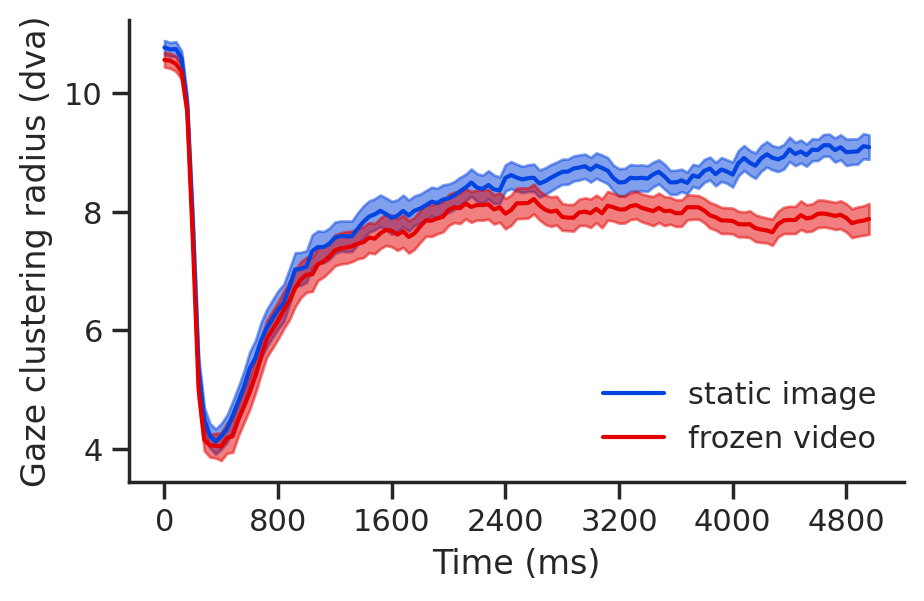

In [17]:
img_color="xkcd:blue"
vid_color="xkcd:red"
fig, ax = plt.subplots(figsize=(5,3), dpi=200)

px2deg = (47.7 * 0.8) / 1920

if RUN_LOCALLY:
    df_r_t_img = pd.read_csv(f"{EVAL_PATH}LPA_5s_r_t_img.csv")
    df_r_t_vid = pd.read_csv(f"{EVAL_PATH}LPA_5s_r_t_vid.csv")

img_mean = df_r_t_img.mean(axis=1)
img_sem = df_r_t_img.sem(axis=1)
ax.plot(img_mean * px2deg, label=f"static image", color=img_color, lw=1.5)
ax.fill_between(
    img_mean.index,
    (img_mean - img_sem) * px2deg,
    (img_mean + img_sem) * px2deg,
    alpha=0.5,
    color=img_color,
)

vid_mean = df_r_t_vid.mean(axis=1)
vid_sem = df_r_t_vid.sem(axis=1)
ax.plot(vid_mean * px2deg, label=f"frozen video", color=vid_color, lw=1.5)
ax.fill_between(
    vid_mean.index,
    (vid_mean - vid_sem) * px2deg,
    (vid_mean + vid_sem) * px2deg,
    alpha=0.5,
    color=vid_color,
)
ax.set_ylabel("Gaze clustering radius (dva)")
ax.set_xlabel("Time (ms)")
ax.set_xticklabels([str(int(i)*40) for i in ax.get_xticks()])

sns.despine(fig)

# no box around legend
plt.legend(loc="lower right", frameon=False)
plt.show()
